In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
from pathlib import Path
import re
import os, sys

# ================== 전처리 자동 파이프라인 (단일 셀) ==================
# 목적: 매번 실행 시 최신 원본/교정 데이터를 읽어 즉시 전처리 → df 확정 → 재집계 셀에서 바로 사용
# 구성:
#   1) 입력 소스 결정 (교정본 있으면 사용, 없으면 원본)
#   2) 로드(다중 인코딩 시도)
#   3) 전처리 (공백 정리, 면적 수치화, 이상치 플래그, 중복 제거)
#   4) 전처리 결과 저장 (preprocessed)
#   5) df / src_path 전역 제공
# ========================================================================

BASE_DIR = Path(r'C:/Users/Woojin Cho/Documents/GitHub/Urban-Refurbishing-Project_DATA-SET/DATA')
RAW_FILE = '핵심단계_구간포함.csv'
PRE_FILE = '핵심단계_구간포함_preprocessed.csv' # 항상 덮어쓰기

raw_path = BASE_DIR / RAW_FILE
pre_path = BASE_DIR / PRE_FILE  # 저장 경로

# 1) 입력 소스 결정
input_path = pre_path if pre_path.exists() else raw_path

# 3) 전처리
work = raw_df.copy()
work.columns = [c.strip() for c in work.columns]
# 진행단계_구간 컬럼명 통일
if '진행단계_구간' not in work.columns:
    for alt in ['핵심단계구간','진행단계구간']:
        if alt in work.columns:
            work.rename(columns={alt:'진행단계_구간'}, inplace=True)
            break

# 필수 컬럼 검사
required_cols = ['자치구','진행단계_구간']
miss_req = [c for c in required_cols if c not in work.columns]
if miss_req:
    raise KeyError(f'필수 컬럼 누락: {miss_req} 실제: {list(work.columns)}')

# 공백/전각 공백 정리 대상
strip_cols = [c for c in ['자치구','진행단계_구간','구역명','정비구역명','정비구역명칭','사업명','사업구역명'] if c in work.columns]

def clean_str(x):
    if pd.isna(x):
        return x
    x = str(x).replace('\u3000',' ').strip()
    x = re.sub(r'\s+',' ', x)
    return x

for c in strip_cols:
    work[c] = work[c].apply(clean_str)

# 면적 수치화 및 과대 플래그
if AREA_COL in work.columns:
    work[AREA_COL] = (work[AREA_COL].astype(str)
                                   .str.replace(',','', regex=False)
                                   .str.replace(' ','', regex=False))
    work[AREA_COL] = work[AREA_COL].str.extract(r'(\d+(?:\.\d+)?)', expand=False)
    work[AREA_COL] = pd.to_numeric(work[AREA_COL], errors='coerce')
    work.loc[work[AREA_COL] <= 0, AREA_COL] = pd.NA
    med_val = work[AREA_COL].median(skipna=True)
    if pd.notna(med_val) and med_val > 0:
        work['면적과대플래그'] = work[AREA_COL] > med_val * 100
    else:
        work['면적과대플래그'] = False
else:
    print(f'[경고] 면적 컬럼({AREA_COL}) 없음')

# 중복 제거 (구역명 + 자치구 + 진행단계_구간 + 면적 동일시 1개 유지)
name_col_pref = next((c for c in ['구역명','정비구역명','정비구역명칭','사업명','사업구역명'] if c in work.columns), None)
subset_keys = ['자치구','진행단계_구간']
if name_col_pref:
    subset_keys = [name_col_pref] + subset_keys
if AREA_COL in work.columns:
    subset_keys_full = subset_keys + [AREA_COL]
else:
    subset_keys_full = subset_keys
before_dups = len(work)
work = work.drop_duplicates(subset=subset_keys_full, keep='first')
removed = before_dups - len(work)
print(f'[중복 제거] {removed}행 제거 (잔여 {len(work)})')

# 자치구 결측 제거
work = work.dropna(subset=['자치구']).copy()
print('[전처리] 자치구 유효 행:', len(work))

# 4) 저장 (항상 덮어쓰기 → 일관성)
work.to_csv(pre_path, index=False, encoding='utf-8-sig')
print(f'[저장 완료] {pre_path.name} (shape={work.shape})')

# 5) df & src_path 확정
src_path = pre_path
df = work  # 이후 셀에서 직접 활용
print('[df 준비 완료]')
if AREA_COL in df.columns:
    print('[면적 통계]\n', df[AREA_COL].describe())

# ========================================================================
# 아래 재집계 셀을 실행해 pivot_df / ratio_df / colors 등을 생성하십시오.
# ========================================================================

[중복 제거] 0행 제거 (잔여 153)
[전처리] 자치구 유효 행: 153
[저장 완료] 핵심단계_구간포함_preprocessed.csv (shape=(153, 45))
[df 준비 완료]
[면적 통계]
 count       137.000000
mean      72886.708905
std       61617.700921
min        1608.000000
25%       26548.970000
50%       59465.000000
75%      103497.400000
max      393729.000000
Name: 정비구역면적(㎡), dtype: float64


In [128]:
# 재집계/파생 변수 생성 셀 (df 로드 후 반드시 실행)
# df 로부터 pivot_df, ratio_df, area_by_gu, colors, count_raw 등을 생성
required_cols = ['자치구','진행단계_구간']
missing_req = [c for c in required_cols if c not in df.columns]
if missing_req:
    raise KeyError(f'재집계 불가 – 필수 컬럼 누락: {missing_req}')

interval_order_fixed = [
    '정비구역지정~조합설립',
    '조합설립~사업시행인가',
    '사업시행인가~관리처분인가',
    '관리처분인가~이전고시'
]
count_raw = df.groupby(['자치구','진행단계_구간']).size().reset_index(name='count')
order_gu = (count_raw.groupby('자치구')['count']
                     .sum()
                     .sort_values(ascending=False)
                     .index)
exist_order = [g for g in interval_order_fixed if g in count_raw['진행단계_구간'].unique()]
extra_order = [g for g in count_raw['진행단계_구간'].unique() if g not in exist_order]
final_order = exist_order + extra_order

pivot_df = (count_raw
            .pivot(index='자치구', columns='진행단계_구간', values='count')
            .reindex(order_gu)
            .fillna(0))
# 컬럼 순서 정렬
after_cols = [c for c in final_order if c in pivot_df.columns]
pivot_df = pivot_df[after_cols]

ratio_df = (pivot_df
            .div(pivot_df.sum(axis=1), axis=0)
            .replace([float('inf'), -float('inf')], 0)
            .fillna(0))

# 색상 팔레트
colors = sns.color_palette('Spectral', n_colors=len(pivot_df.columns)) if len(pivot_df.columns) > 0 else []

# 면적 합계 (있을 때만)
AREA_COL = '정비구역면적(㎡)'
if AREA_COL in df.columns:
    area_by_gu = (df.dropna(subset=[AREA_COL])
                    .groupby('자치구', as_index=False)[AREA_COL]
                    .sum()
                    .sort_values(AREA_COL, ascending=False))
else:
    area_by_gu = None

print('[재집계 완료]')
print(' - pivot_df shape:', pivot_df.shape)
print(' - ratio_df shape:', ratio_df.shape)
if area_by_gu is not None:
    print(' - area_by_gu shape:', area_by_gu.shape)
print(' - 구간 컬럼:', list(pivot_df.columns))

[재집계 완료]
 - pivot_df shape: (22, 3)
 - ratio_df shape: (22, 3)
 - area_by_gu shape: (22, 2)
 - 구간 컬럼: ['정비구역지정~조합설립', '사업시행인가~관리처분인가', '관리처분인가~이전고시']


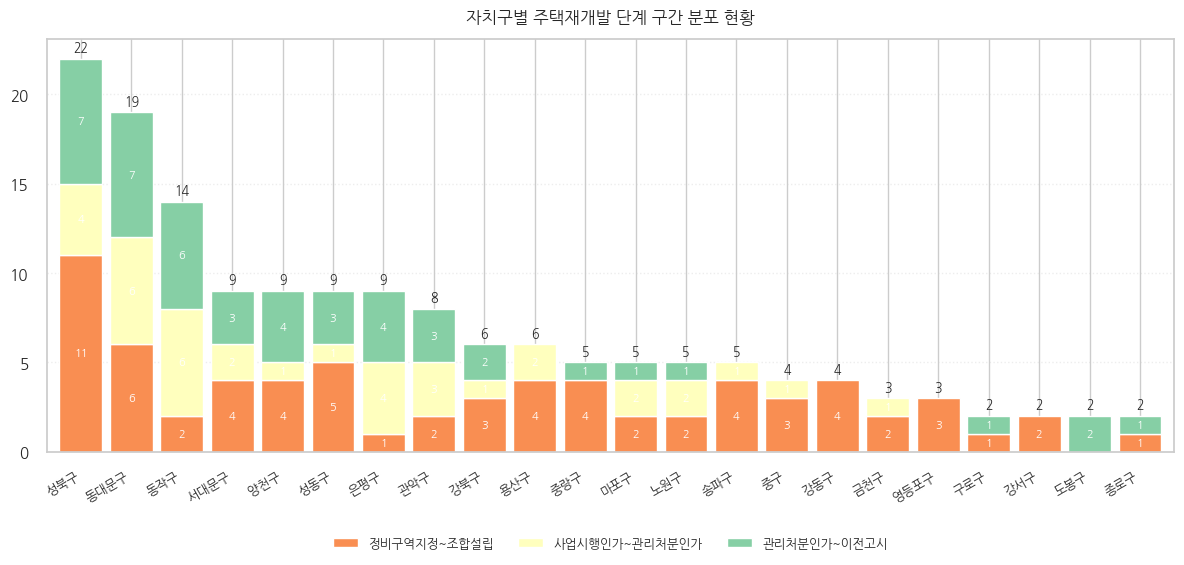

In [125]:

fig, ax_bar = plt.subplots(figsize=(12, 6))
ax_bar = pivot_df.plot(
    kind='bar',
    stacked=True,
    color=colors if 'colors' in globals() else sns.color_palette('Spectral', n_colors=len(pivot_df.columns)),
    width=0.85,
    ax=ax_bar
)
ax_bar.set_title('자치구별 주택재개발 단계 구간 분포 현황', pad=12)
ax_bar.set_xlabel('')
ax_bar.grid(axis='y', linestyle=':', alpha=0.35)
ax_bar.set_axisbelow(True)
plt.setp(ax_bar.get_xticklabels(), rotation=30, ha='right', fontsize=9)

totals = pivot_df.sum(axis=1)
for x, total in zip(ax_bar.get_xticks(), totals):
    ax_bar.text(x, total + max(totals)*0.01, int(total), ha='center', va='bottom', fontsize=9)

for container in ax_bar.containers:
    labels = []
    for rect in container:
        h = rect.get_height()
        # 해당 bar index 계산
        bar_idx = int(rect.get_x() + rect.get_width()/2 + 1e-6)
        denom = totals.iloc[bar_idx]
        if denom > 0 and h <= denom * 0.08:
            labels.append('')
        else:
            labels.append(int(h))
    ax_bar.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

ax_bar.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.18),
    ncol=len(pivot_df.columns),
    frameon=False,
    fontsize=9,
    title_fontsize=10
)
plt.subplots_adjust(bottom=0.30)
plt.tight_layout(rect=(0,0.05,1,1))
plt.show()

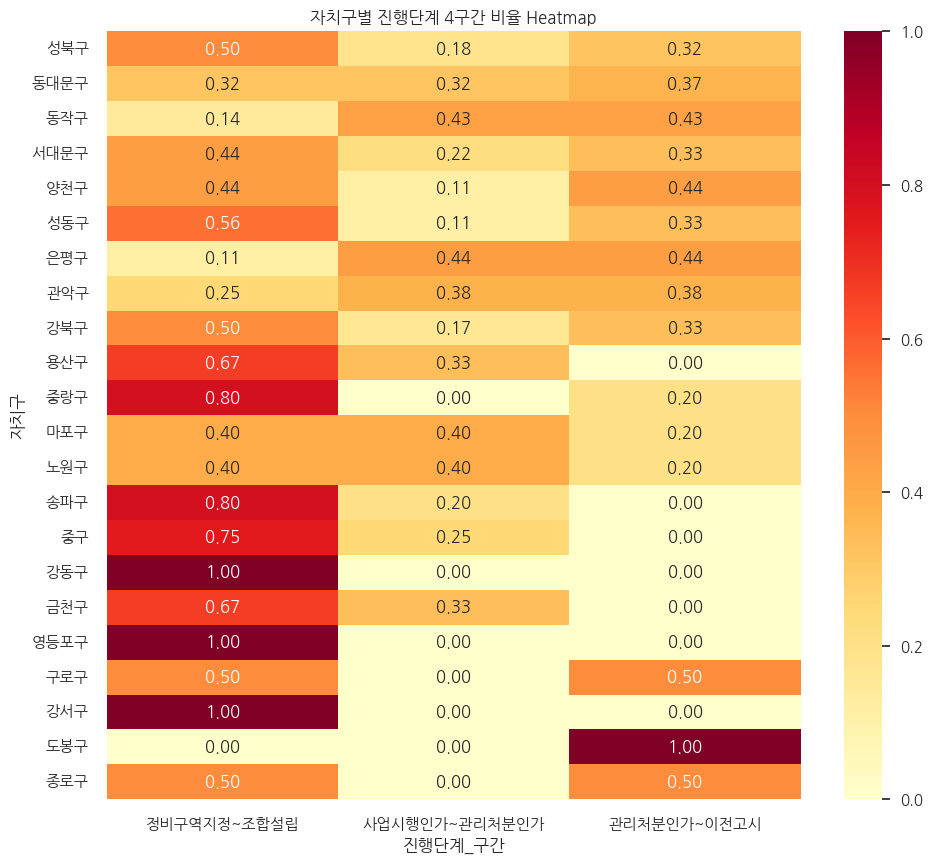


[요약 상위 5행]
   자치구        진행단계_구간  count
0  강동구    정비구역지정~조합설립      4
1  강북구    관리처분인가~이전고시      2
2  강북구  사업시행인가~관리처분인가      1
3  강북구    정비구역지정~조합설립      3
4  강서구    정비구역지정~조합설립      2

[구간 순서 적용] -> ['정비구역지정~조합설립', '사업시행인가~관리처분인가', '관리처분인가~이전고시']
[자치구 수] 22 | [구간 수] 3


In [126]:
# Heatmap (재집계 ratio_df 사용)
if 'ratio_df' not in globals():
    raise RuntimeError('ratio_df가 없습니다. 재집계 셀을 먼저 실행하세요.')
plt.figure(figsize=(10, max(4, len(ratio_df)*0.4)))
sns.heatmap(ratio_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('자치구별 진행단계 4구간 비율 Heatmap')
plt.xlabel('진행단계_구간')
plt.ylabel('자치구')
plt.tight_layout()
plt.show()

print('\n[요약 상위 5행]')
print(count_raw.head())
print('\n[구간 순서 적용] ->', final_order)
print('[자치구 수]', pivot_df.shape[0], '| [구간 수]', pivot_df.shape[1])